In [ ]:
%load_ext tensorboard

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt
from keras.backend import backend

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tvDatafeed import TvDatafeed, Interval

import datetime

from IPython.display import clear_output
import func

from typing import Literal

In [7]:
batch_size=32
dir_log="../models/"+ datetime.datetime.now().strftime("%d-%h-%H.%M")
dir_log

username = 'rheyhantensor'
password = '$Acong091283'
tv = TvDatafeed(username, password)

In [33]:
#modelling things        
def tensorboardlogger():
    return [keras.callbacks.ModelCheckpoint(dir_log+"/callbacks", save_weights_only=True),
            tf.keras.callbacks.TensorBoard(dir_log)]
    
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, totepochs, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
        self.totepochs=totepochs
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        if epoch==self.totepochs-1:
            clear_output()
        super().on_epoch_begin(epoch, *args, **kwargs)
        

#create model

def getdata(theinterval: Literal[Interval.in_1_hour, Interval.in_daily, Interval.in_weekly, Interval.in_monthly],
             startfromyear: int,
             showplot: bool= False,
             save: bool = False):
    
    data=tv.get_hist(symbol='BTCUSD',exchange='BITSTAMP', interval=theinterval, n_bars=10000000).iloc[:,1]
    data=data[data.index.year >= startfromyear]
    
    if showplot:
        fig = plt.figure(figsize=(12,5))
        ax = fig.add_subplot(1,1,1)
        ax.plot(data, c="blue", label= "dataset")
        ax.legend(loc="upper right")
        ax.set_xlabel("period")
        ax.set_ylabel("USD ($)")
        
    if save:
        data.to_csv(f'../datasets/{str(theinterval)}')
    return data
    
class modelmaker():
    '''This class is used for making a model.'''
    
    def __init__(self, 
                 data: pd.DataFrame):
        '''Initiate the data that's gonnna be used'''
        
        self.data=data
        self.scaler()
        
    def scaler(self):
        '''Important before being used, automatically on work'''
        
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler.fit(self.data.values.reshape(-1,1))
        self.scaled_data=self.scaler.transform(self.data.values.reshape(-1,1))
    
    def traintestsplit(self, 
                       train_size: float=0.8, 
                       showplot: bool=True):
        '''Train Test splitting the subjected data, showplot=True will show the partition of the dataset.'''
        
        if showplot:
            fig=plt.figure(figsize=(15,10))
            
            #train
            ax=fig.add_subplot(2,2, 1)
            ax.plot(self.data[:int(train_size*len(self.data))], c="blue", label="train")
            ax.set_title("Train Data")
            
            #Test
            ax=fig.add_subplot(2,2, 2)
            ax.plot(self.data[int(train_size*len(self.data)):], c="orange", label="test")
            ax.set_title("Test Data")
            
            #Both
            ax=fig.add_subplot(2,1,2)
            ax.plot(self.data[:int(train_size*len(self.data))], c="blue", label="train")
            ax.plot(self.data[int(train_size*len(self.data)):], c="orange", label="test")
            ax.grid("on", alpha=0.3)
            ax.legend(loc="upper right")
            ax.set_title("BTC Price")
            ax.set_ylabel("Price ($)")
            ax.set_xlabel("Timestamp")
        
        self.train_scaled=self.scaled_data[:int(train_size*len(self.data))]; self.test_scaled=self.scaled_data[int(train_size*len(self.data)):]
        
        
    def givelagvariable(self,
                        t: int =1):
        '''Giving lag variable to the dataset, t default=1, also being used for the independent variable'''
        
        self.t=t
        self.trainX, self.trainY= func.givelagvariable(self.train_scaled, t)
        self.testX, self.testY= func.givelagvariable(self.train_scaled, t)
        # reshape input to be [samples, features, time steps] so it can be fitted in the model
        self.trainX = np.reshape(self.trainX, (self.trainX.shape[0], self.trainX.shape[1], 1))
        self.testX = np.reshape(self.testX, (self.testX.shape[0], self.testX.shape[1], 1))
        self.getmodel_compile()
                
    def getmodel_compile(self):
        '''Get the model ands its compiler'''
        
        model=keras.Sequential([
            keras.layers.LSTM(4, input_shape=(self.t, 1), return_sequences=True),
            keras.layers.LSTM(8),
            keras.layers.Dropout(0.05),
            keras.layers.Dense(1)])
        
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
        self.model=model
    
    def fit(self, 
            epoch:int=100):
        '''Fitting the model.'''
        self.thehistory=self.model.fit(self.trainX, self.trainY, epochs=epoch, validation_data=(self.testX, self.testY), 
                             batch_size=batch_size, verbose=0,
                             callbacks=[tensorboardlogger(), SelectiveProgbarLogger(verbose=1, epoch_interval=1, totepochs=epoch)])

#Daily

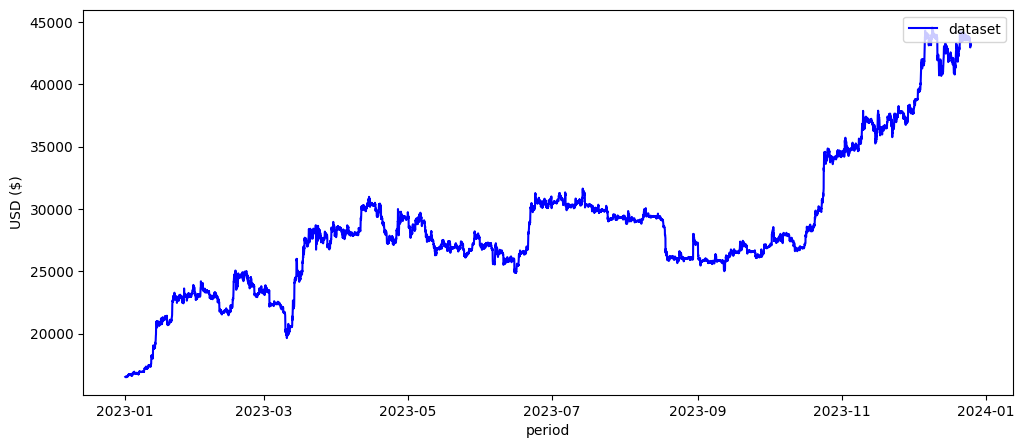

In [35]:
#train for daily, startimg from 2017. I think
data=getdata(theinterval=Interval.in_1_hour, startfromyear=2017, showplot=True, save=True)

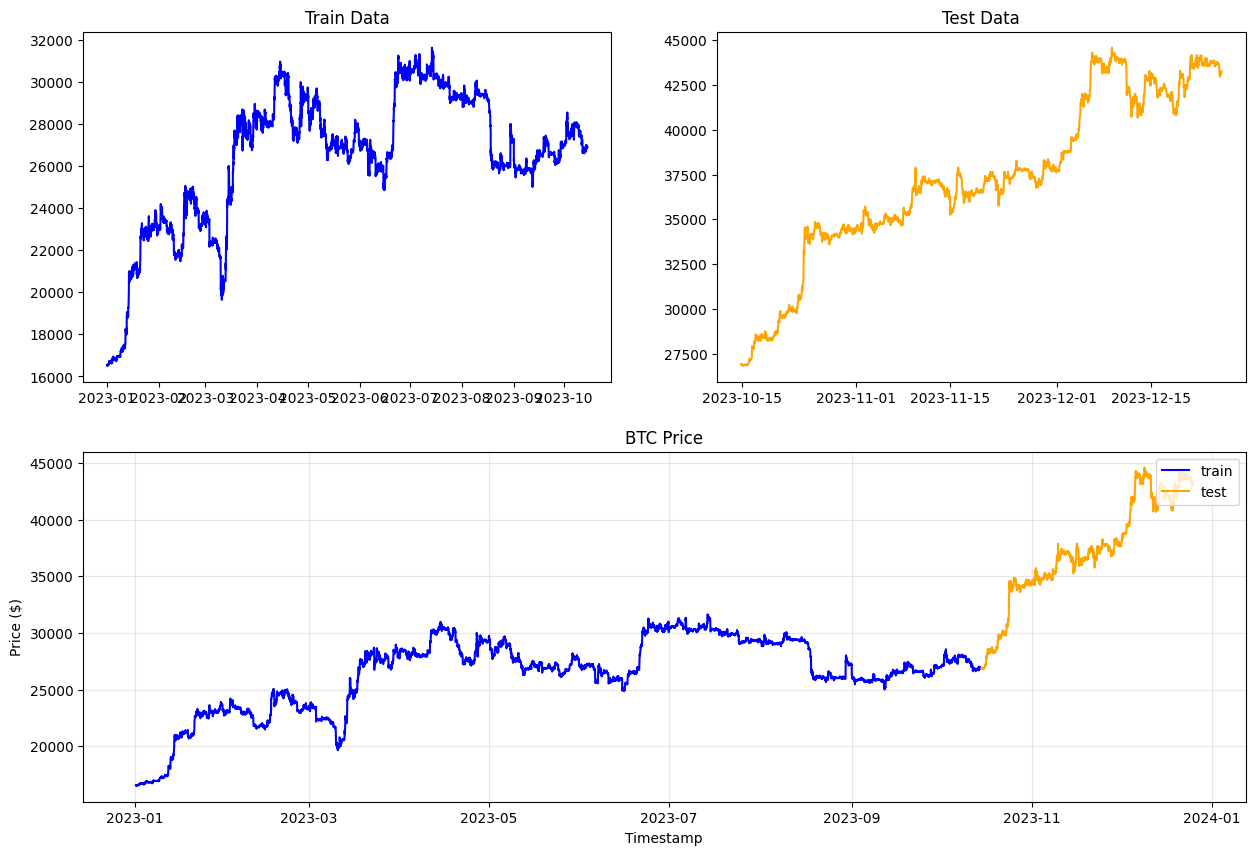

In [36]:
test1=modelmaker(data)
test1.traintestsplit(0.8)

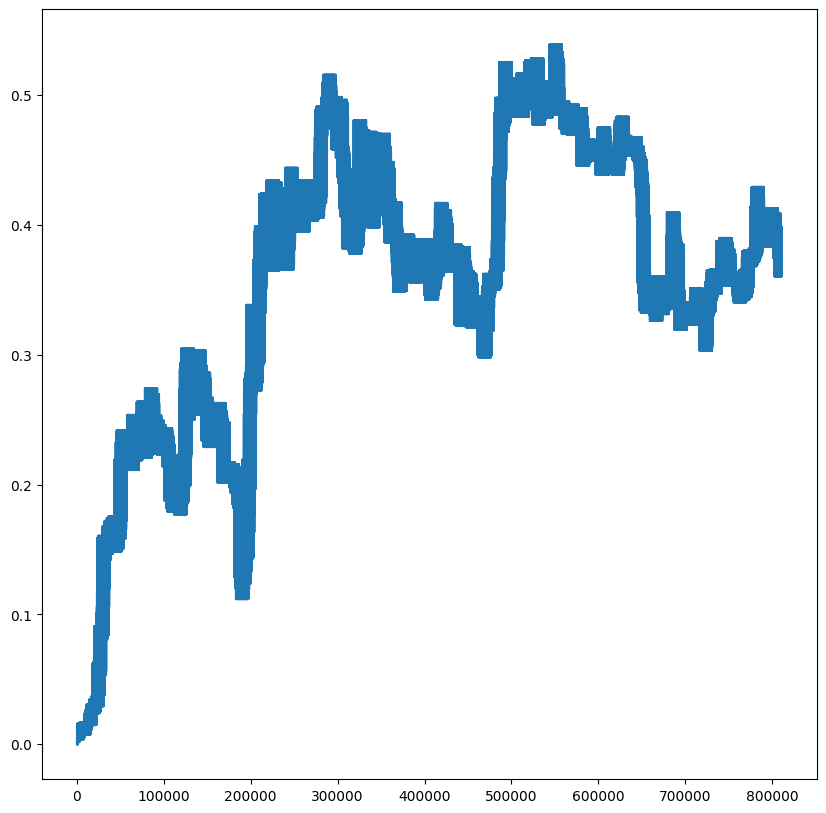

In [44]:
test1.givelagvariable(t=120)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(test1.trainX.flatten())